In [95]:
%matplotlib widget

from IPython.display import Markdown
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np

## Primary Coil Parameters

In [96]:
# Coil Geometry
r_0     = 0.1   # [m] Outer radius
N       = 10    # [1] Number of turns
z_0     = 0     # [m] Vertical Position

# Simulation discretization
d_theta = 0.1   # [rad] Angle between points
d_eucl  = 0.05  # [m] Mesh discretization for plotting
# x-axis
x_min   = -0.2  # [m] Minimum x value for plotting   
x_max   = +0.3  # [m] Minimum x value for plotting 
# y-axis
y_min   = -0.2  # [m] Minimum x value for plotting   
y_max   = +0.3  # [m] Minimum x value for plotting 
# z-axis
z_min   = 0.02  # [m] Minimum x value for plotting   
z_max   = +0.52  # [m] Minimum x value for plotting 

# Physics constants
mu_0    = 4*np.pi*1e-7 # [H/m] Permeability of free space

## Coil Discretization
We first define a spiral in polar coordinates as
$$
    r(\theta) =  r_0 \frac{\theta}{2\pi N} \ , \quad 0 \le \theta \le 2\pi N.
$$
We then transform the euqations in cartesian coordinates
$$
    x(r, \theta) = r\cos\theta = r_0 \frac{\theta}{2\pi N} \cos\theta,
$$
$$
    y(r, \theta) = r\sin\theta = r_0 \frac{\theta}{2\pi N} \sin\theta.
$$
Therefore we can discretize both $x$ and $y$ to get
$$
    x_i = r_0 \frac{i\Delta\theta}{2\pi N} \cos(i\Delta\theta),
$$
$$
    y_i = r_0 \frac{i\Delta\theta}{2\pi N} \sin(i\Delta\theta),
$$
with $i = 0, 1, \dots, \frac{2\pi N}{\Delta\theta}$.

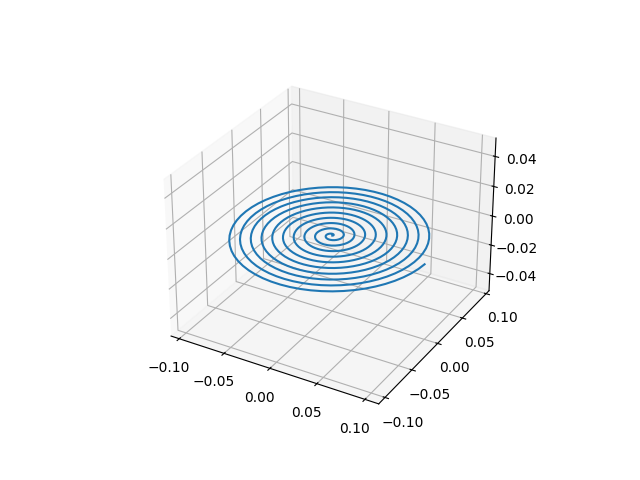

In [97]:
i = np.arange(1, 2*np.pi*N/d_theta, 1)
x = r_0 * i * d_theta / (2 * np.pi * N) * np.cos(d_theta * i)
y = r_0 * i * d_theta / (2 * np.pi * N) * np.sin(d_theta * i)
z = 0*i + z_0

ax = plt.figure().add_subplot(projection='3d')
plt.plot(x, y, z)

## Biot-Savart Law
The magnetic field $\mathrm{d}\vec{B}(\vec{r})$ contribution given by a short uniform segment of wire $\mathrm{d}\vec{l}$ carrying a current $I$ and at position $\vec{r}_w$ is given by
$$
\mathrm{d}\vec{B}(\vec{r}) = \frac{\mu_0 I}{4\pi} \frac{\mathrm{d}\vec{l} \times (\vec{r} - \vec{r_w})}{\left|\vec{r} - \vec{r_w}\right|^3}.
$$
Therefore the total contribution of the wire $\gamma$ is given by the integral of the form
$$
\vec{B}(\vec{r}) = \frac{\mu_0 I}{4\pi} \int_\gamma \frac{\mathrm{d}\vec{l} \times (\vec{r} - \vec{r_w})}{\left|\vec{r} - \vec{r_w}\right|^3}
$$
This can be easily discretized by considering the Reimann integral as a sum of small sections of wire $\Delta \vec{l}_i$
$$
\vec{B}(\vec{r}) = \frac{\mu_0 I}{4\pi} \sum_{i}  \frac{\Delta\vec{l}_i \times (\vec{r} - \vec{r_w})}{\left|\vec{r} - \vec{r_w}\right|^3}
$$

In [98]:
def dB(r, x, y, z, i, I):
    r_w = np.array([x[i], y[i], z[i]])
    r_w2 = np.array([x[i + 1], y[i + 1], z[i + 1]])
    dl = r_w2 - r_w
    Dr = r - r_w
    return (mu_0 * I) / (4 * np.pi) * np.cross(dl, Dr) / np.linalg.norm(Dr)**3

def B(r, x, y, z, I):
    sum = np.array([0, 0, 0])
    for i in range(len(x) - 1):
        sum = sum + dB(r, x, y, z, i, I)
    return sum

In [99]:
x_p, y_p, z_p = np.meshgrid(np.arange(x_min, x_max, d_eucl),
                            np.arange(y_min, y_max, d_eucl),
                            np.arange(z_min, z_max, d_eucl))

dim = x_p.shape
b_x = np.zeros(dim)
b_y = np.zeros(dim)
b_z = np.zeros(dim)

I = 1 # Current is normalized to one

for i in range(dim[0]):
    for j in range(dim[1]):
        for k in range(dim[2]):
            r = np.array([x_p[i][j][k], y_p[i][j][k], z_p[i][j][k]])
            B_vec = B(r, x, y, z, I)
            B_vec = B_vec
            b_x[i][j][k] = B_vec[0]
            b_y[i][j][k] = B_vec[1]
            b_z[i][j][k] = B_vec[2]

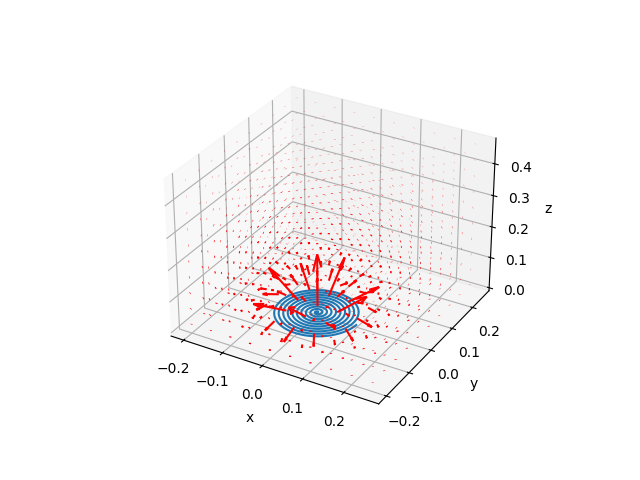

In [100]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.quiver(x_p, y_p, z_p, b_x, b_y, b_z, length=2e3, color='r')
ax.plot(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

## Secondary Coil Parameters

In [110]:
# Geometry
rs      = 0.05   # [m] Outer radius
Ns      = 20  # [1] Number of computational turns
N_group   = 50   # [1] Grouping of coils into a single one (computation) -> Ns_eff = Ns * group 
h       = 0.5   # [m] Height of the coil

# Drawing parameters
d_theta_draw    = 0.1
d_eucl_flux     = 0.005

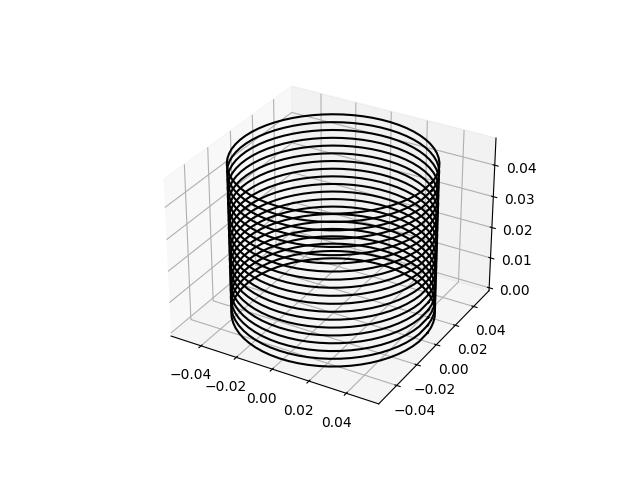

In [111]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

i = np.arange(1, 2*np.pi/d_theta, 1)
x_s = rs * np.cos(d_theta_draw * i)
y_s = rs * np.sin(d_theta_draw * i)

x_s = np.append(x_s, x_s[0])
y_s = np.append(y_s, y_s[0])

z_s = h/Ns*np.linspace(0, Ns-1, Ns)

for z_s_ in z_s:
    plt.plot(x_s, y_s, z_s_*np.ones(y_s.size), color='black')
    

In [112]:
x_ps, y_ps, z_ps = np.meshgrid(np.arange(x_min, x_max, d_eucl),
                            np.arange(y_min, y_max, d_eucl),
                            np.arange(z_min, z_max, d_eucl))

dim = x_ps.shape
bs_x = np.zeros(dim)
bs_y = np.zeros(dim)
bs_z = np.zeros(dim)

I = 1 # Current is normalized to one

for i in range(dim[0]):
    for j in range(dim[1]):
        for k in range(dim[2]):
            for z_s_ in z_s:
                z_s_array = np.ones(x_s.shape)*z_s_
                r = np.array([x_ps[i][j][k], y_ps[i][j][k], z_ps[i][j][k]])
                B_vec = B(r, x_s, y_s, z_s_array, I)
                B_vec = B_vec
                bs_x[i][j][k] = bs_x[i][j][k] + B_vec[0]
                bs_y[i][j][k] = bs_y[i][j][k] + B_vec[1]
                bs_z[i][j][k] = bs_z[i][j][k] + B_vec[2]

## Calculating $M$
To calculate the mutual inductance between the primary and secondary coils we apply the definition of mutual inductance $M$, namely
$$
M = \frac{\Phi}{I},
$$
where $\Phi$ is the flux through the secondary coil and $I$ is the current in the primary coil (in this case normalized to $1 \mathrm{A}$). the flux through a surface $S$ is calculated as
$$
\Phi = \iint_S \vec{B}\cdot\mathrm{d}\vec{A}.
$$

While this should be calculated for each single turn of wire of the secondary and then added, we decided to group it in bunches for a better performance on the computer.

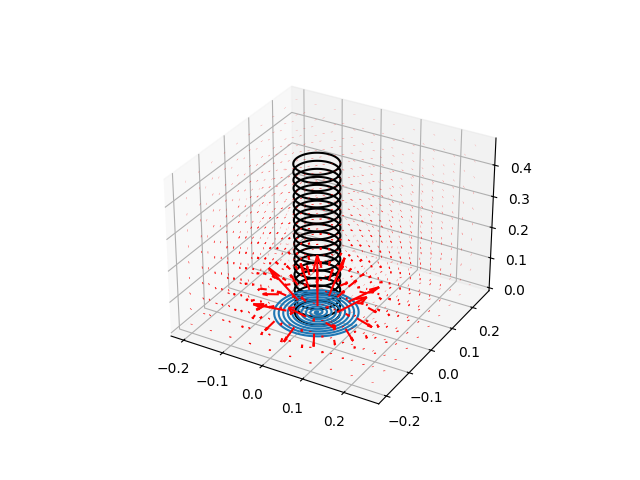

In [105]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for z_s_ in z_s:
    plt.plot(x_s, y_s, z_s_*np.ones(y_s.size), color='black')
    
ax.quiver(x_p, y_p, z_p, b_x, b_y, b_z, length=2e3, color='r')
ax.plot(x, y, z)

In [106]:
def Phi(radius, z_coil, step, B_modified):
    x_c = np.arange(-radius, +radius, step)
    y_c = np.arange(-radius, + radius, step)
    total_flux = 0
    normal = np.array([0, 0, step*2]) # Normal vector
    for x_ in x_c:
        for y_ in y_c:
            if x_**2 + y_**2 > radius**2:
                continue # Outside of the coil
            B_res = B_modified(x_, y_, z_coil)
            total_flux = np.dot(normal, B_res)
    
    return total_flux

def B_mod(x_i, y_i, z_i):
    r = np.array([x_i, y_i, z_i])
    return B(r, x, y, z, I)

total_flux = 0
for z_s_ in z_s:
    total_flux = total_flux + N_group*Phi(rs, z_s_, d_eucl_flux, B_mod)
    
result_markdown = f"**Calculated Mutual Inductance:** {total_flux*1e6} uH"
display(Markdown(result_markdown))
    

**Calculated Mutual Inductance:** 116.35780275065221 uH

## Calculating $L_s$
A simimar approach to what has been outlined above can be used to find the secodnary coil self-indictance $L_s$.

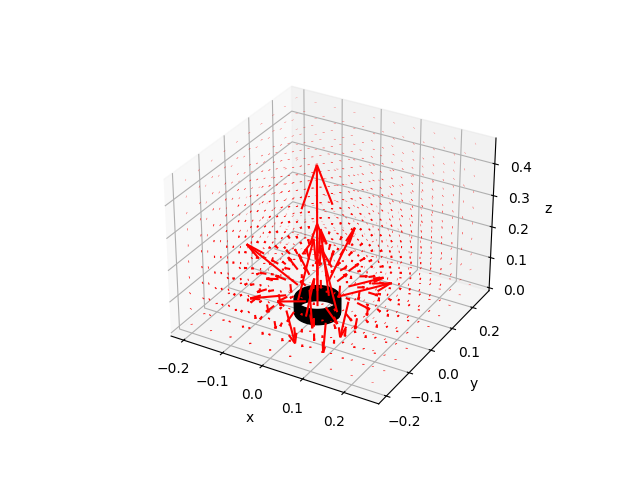

In [113]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.quiver(x_ps, y_ps, z_ps, bs_x, bs_y, bs_z, length=2e3, color='r')

for z_s_ in z_s:
    plt.plot(x_s, y_s, z_s_*np.ones(y_s.size), color='black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [114]:
def B_mod_s(x_i, y_i, z_i):
    total_field = 0
    for z_s_ in z_s:
        z_s_array = np.ones(x_s.shape)*z_s_
        r = np.array([x_i, y_i, z_i])
        total_field = total_field + B(r, x_s, y_s, z_s_array, I)
    return total_field

total_flux = 0
for z_s_ in z_s:
    total_flux = total_flux + N_group*Phi(rs, z_s_, d_eucl_flux, B_mod_s)
    
result_markdown = f"**Calculated Secondary Inductance:** {total_flux*1e3} mH"
display(Markdown(result_markdown))

**Calculated Secondary Inductance:** 3.927755408124576 mH